# [MODI (**M**ulticommodity **O**ptimal transport **D**ynamics on **I**mages)](https://github.com/aleable/MODI)

#### Contributors:

- Alessandro Lonardi
- Diego Baptista
- Caterina De Bacco

In [1]:
import nbimporter
import utils
from main import MODI
from main import * # for transport network construction

## Preprocessing dataset
With this first code snippet we preprocess the dataset, containing ```N = 10``` images. The preprocessing consists of two steps:

- *cropping* the images to the smallest size that is divisible by the pooling mask
- *average pooling* the images

Hence, the only parameter we need to pass is the average pooling (square) mask size: ```ms```.

The processed images are saved in a dataframe with ```N``` rows of the form ```{'image': np.array(image), 'label': int(label)}```. I.e., the samples are converted to a ```np.array``` and associated to a label (each angiosperm species is assigned a unique integer).

In [2]:
ms = 40
flowers_dataframe = utils.preprocessing(ms)

100%|██████████| 10/10 [00:00<00:00, 18.96it/s]


The dataset can be visualized as follows

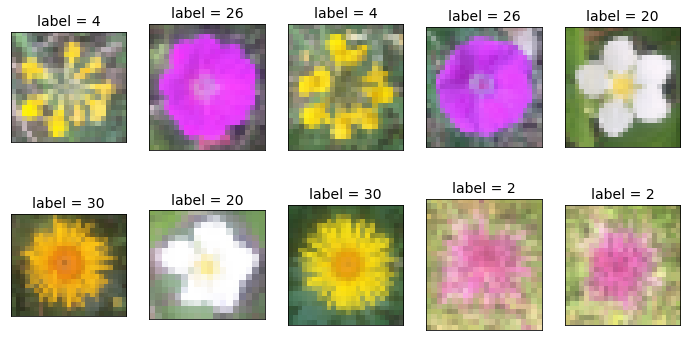

In [3]:
utils.visualize_dataset(flowers_dataframe)

## Multicommodity OT dynamics

In the remaining part of the code, we:
1. build the transport network on which our dynamics is executed
2. run the agorithm

Briefly,

1. A pair of image is converted into a pair of tensors $\{ G,H \}$, of sizes $m \times M$, and $n \times M$, $M=3$. These tensors are transported on a transport network $K(V,E)$, which is made of $E_{12} \subset E$ edges with cost $C_e(\theta,\tau)$, defined as follows:

\begin{align*}
C_e(\theta, \tau) = \min \{(1-\theta)||\mathrm{v}_i-\mathrm{v}_j||_2 + \theta || G_{ij} - H_{ij}||_1, \tau\}.
\end{align*}

The vector $\mathrm{v} = (x,y)$ contains pixels' coordinates, $\theta \in [0,1]$ is a convex combination weight, and $\tau > 0$ a trimming threshold used to cut costly edges. To the edges in $E_{12}$, we add $n+m$ transshipment connections with cost $\tau/2$, that are linking the two bipartite set of nodes $V_1$ and $V_2$ via an auxiliary transshipment node, $u_1$. Morover, we also add $n$ connections between a second auxiliary node, $u_2$, and $V_2$, to enforce Kirchhoff's law. Each of these connections costs $c = max_{e \in E_{12}}{C_e}/2$.

2. The optimal transport problem is solved by integrating the following system of equations:

\begin{alignat}{2}
\label{eqn:kirchhoff}
 &\sum_{j \in \partial i} L_{ij}[x] \phi_j^a = S_i^a, &&\forall i \in V, a = 1,\dots, M\\
 \label{eqn:dynamics}
 &\frac{dx_e}{dt} = x_e^\beta \frac{|| \phi_i - \phi_j||^2_2}{C_e^2} - x_e \quad &&\forall e = (i,j) \in E,
\end{alignat}
which constitute the pivotal equations of our model. Here $x_e \geq 0$ are shared conductivities; $S_{ia} = G_{ia} - H_{ia}$; and with $L_{ij}[x] = \sum_e (x_e/C_e) B_{ie}B_{je}$ we denote the weighted Laplacian of $K$. Lastly, $\phi^a_i$ are scalar potentials acting on nodes, for a fixed commodity $a$. Least-square solutions of the first equation, Kirchhoff's law, are $\phi_i^a [x] = \sum_j L^\dagger_{ij}[x] S^a_i$, where $\dagger$ denotes the Moore-Penrose inverse. 

Crucially, defining $P^a_e(t) = x_e(t)(\phi^a_i[x(t)] - \phi^a_j[x(t)])/C_e$ for $e = (i,j)$, it is possible to prove that $lim_{t\to+\infty} P(t) = P^\star$. Here, $P^\star$ is a minimizer of:
    \begin{align*}
    \min_P \sum || P_{ij} ||^\Gamma_2 C_{ij},
    \end{align*}
with $\Gamma = 2(2-\beta)/(3-\beta)$. Thus, calculating asymptotic solutions of the multicommodity dynamics we can retrieve optimal transport paths $P^\star$.

## Setup

**Hyperparameters for OT setup**

In [4]:
otp_alg = "multicom" # "multicom"/"unicom" for M=3 and M=1, respectively
sigma = 0.5          # in case additional gaussian smoothing of the images is desired
pooling_size = 1     # in case further pooling of the images is desired
theta = 0.5          # convex weight for the construction of C
alpha = 0.5          # penalty for Kirchhoff's law (https://ieeexplore.ieee.org/document/5459199)

**Hyperparameters to run the solver**

In [5]:
time_step = 0.5  # forward Euler discretization time step
tol = 1e-1       # convergence tolerance
time_tol = 1e3   # stopping time step limit (for safety)
beta = 1.0       # regularization parameter

seed = 0
VERBOSE = False

Select two samples

In [6]:
img1 = flowers_dataframe["image"][0]
img2 = flowers_dataframe["image"][1]

In [7]:
C, g, h = preprocessing(img2, img1, otp_alg, pooling_size, sigma, theta)
thresh = 0.05  # trimming threshold (https://ieeexplore.ieee.org/document/5459199)

## Running the scheme

In [8]:
modi = MODI(g, h, C,
                   beta=beta,
                   dt=time_step,
                   tol=tol,
                   time_tol=time_tol,
                   alpha=alpha,
                   t=thresh,
                   verbose=VERBOSE)

info_dyn = modi.exec()

In [9]:
print("Optimal transport cost =", info_dyn[0])

Optimal transport cost = 6789.525322674113


## A slightly bigger experiment

Comparing the first sample against the rest of the dataset

In [10]:
img1 = flowers_dataframe["image"][0]
img_list = [flowers_dataframe["image"][i] for i in [1,2,3,4,5,6,7,8,9]]

lab1 = flowers_dataframe["label"][0]
lab_list = [flowers_dataframe["label"][i] for i in [1,2,3,4,5,6,7,8,9]]

In [11]:
j_list = list()
for img2 in img_list:
    
    C, g, h = preprocessing(img2, img1, otp_alg, pooling_size, sigma, theta)
    thresh = 0.05  # trimming threshold

    modi = MODI(g, h, C,
                       beta=beta,
                       dt=time_step,
                       tol=tol,
                       time_tol=time_tol,
                       alpha=alpha,
                       t=thresh,
                       verbose=VERBOSE)

    info_dyn = modi.exec()
    j_list.append(info_dyn[0])

We can plot the optimal cost ($J^\star_\Gamma$) landscape obtained when comparing one test image against the others, and see if the minimum cost corresponds to a flower belonging to the same class of the test sample!

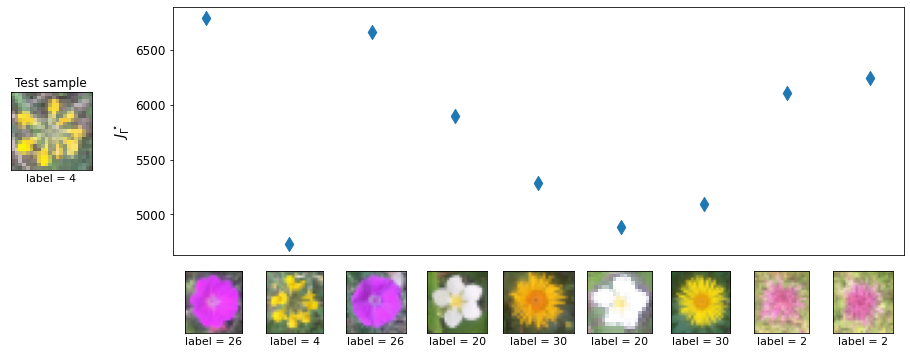

In [12]:
utils.visualize_resuts(img1, img_list, lab1, lab_list, j_list)